In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xlrd

In [2]:
# Read the data
df = pd.read_csv("data/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


#### NOTES: 
- Variety of ingredients that composed variety of concrete.  
- I need to do something, for example adding a synthetic features derived from these to be fed into a model

#### What to do?
1. First I need to establish a baseline by training the model on the original dataset. This will tell whether the features are actually useful or not.
2. Establishing a baseline is always a good practice at the start of the process of feature engineering. The score of the baseline will tell whether the features are worth keeping, or whether they need to be discarded and possibly try something else.

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)

baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


In [4]:
# Create synthetic feature
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)

score = -1 * score.mean()
print(f"MAE Baseline Score: {score:.4}")

MAE Baseline Score: 7.948


## How to evaluate features?

New dataset give confusion, because we do not know which features are useful and which are not.  In order to know that, we must rank the features we have regarding to their contribution to the target variable. We can use **feature utility metric** to see the relationship between the predictors or the features and the target. There are many metrics but I'll use **mutual informatio** in this case. This metric is a lot like correlation for its ability to detect relationship between x and y. While correlation can only detect linear relationship, **MI** can detect any kind of relationship.

### Mutual Information
In simple definition, **Mutual Information** measures uncertainty. I can describe it like this: to what extent the information provided by X reduces the uncertainty of Y. 

_Technical note_: 
Uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions we would need to describe an occurance of that variable, on average." The more questions we have to ask, the more uncertain we must be about the variable. Mutual information is how many questions we expect the feature to answer about the target.

### Mutual Information Score
The minimum score of MI between x and y is 0.0. If the score is 0, we can say that both x and y are independent, meaning that there is no relationship between them. On the other hand, there is no upper limit of MI score, but in practice, MI score above 2 is not common. 

**Things to remember when applying mutual information:**
- MI can help us to understand the relative potential of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
- The actual usefulness of a feature is not absolute but depends on the model we use with it. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

# Practicing MI

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv("data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


I will use MI from scikit learn.
NOTES:
- MI scikit learn treats discrete and continuous features differently
- As consequence we need to tell the it (MI scikit learn) which are which. 
- float is of course not discrete
- categorical is categorical but can be treated as discrete by giving them label encoding. 

In [6]:
X = df.copy()
y = X.pop("price")

# label encoding for categorical
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes
discrete_features = X.dtypes == int

In [7]:
X

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
1,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
2,1,0,0,0,2,1,0,0,94.5,171.2,...,6,152,0,2.68,3.47,9,154,5000,19,26
3,2,1,0,0,4,2,1,0,99.8,176.6,...,4,109,0,3.19,3.40,10,102,5500,24,30
4,2,1,0,0,4,2,2,0,99.4,176.6,...,5,136,0,3.19,3.40,8,115,5500,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-1,20,0,0,4,2,0,0,109.1,188.8,...,4,141,0,3.78,3.15,9,114,5400,23,28
189,-1,20,0,1,4,2,0,0,109.1,188.8,...,4,141,0,3.78,3.15,8,160,5300,19,25
190,-1,20,0,0,4,2,0,0,109.1,188.8,...,6,173,0,3.58,2.87,8,134,5500,18,23
191,-1,20,1,1,4,2,0,0,109.1,188.8,...,6,145,5,3.01,3.40,23,106,4800,26,27


In [8]:
y

0      13495
1      16500
2      16500
3      13950
4      17450
       ...  
188    16845
189    19045
190    21485
191    22470
192    22625
Name: price, Length: 193, dtype: int64

In [9]:
discrete_features

symboling             True
make                  True
fuel_type             True
aspiration            True
num_of_doors          True
body_style            True
drive_wheels          True
engine_location       True
wheel_base           False
length               False
width                False
height               False
curb_weight           True
engine_type           True
num_of_cylinders      True
engine_size           True
fuel_system           True
bore                 False
stroke               False
compression_ratio     True
horsepower            True
peak_rpm              True
city_mpg              True
highway_mpg           True
dtype: bool

NOTE: 

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (`mutual_info_regression`) and one for categorical targets (`mutual_info_classif`). "price" is real-valued.

#### Computes the MI scores for features and save them in a nice dataframe

In [10]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

curb_weight          1.528808
highway_mpg          0.958728
length               0.614604
bore                 0.498874
stroke               0.375836
drive_wheels         0.333127
compression_ratio    0.133968
fuel_type            0.047279
Name: MI Scores, dtype: float64

I, next make bar plot amomg features for comparison

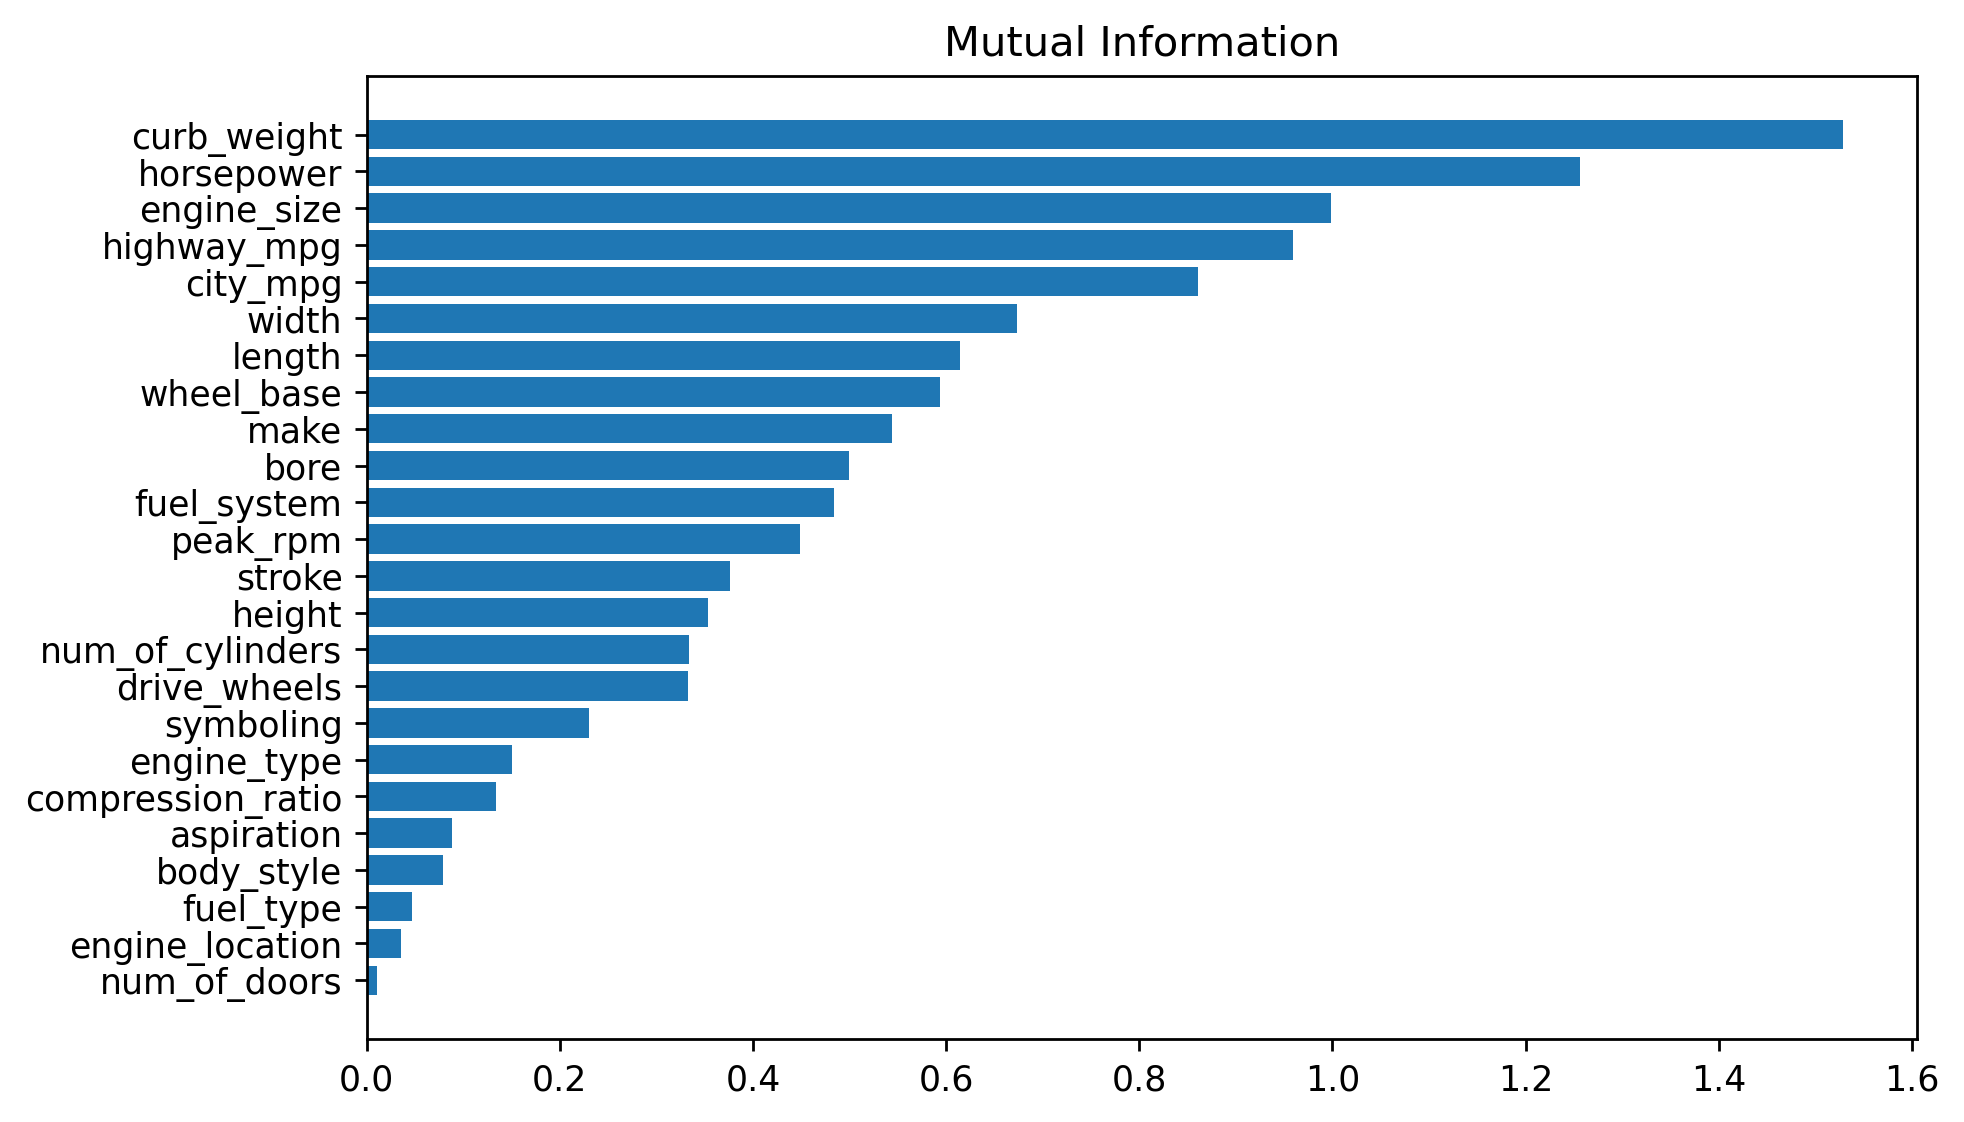

In [11]:
def plot_mi_scores(scores):
    scores = scores.sort_values()
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information")

plt.figure(dpi=250, figsize=(8, 5))
plot_mi_scores(mi_scores)

The visualization above is just a confirmation of the ranking I compute before. And it is confirmed that curb_weight is the stongest variable in relations to y.

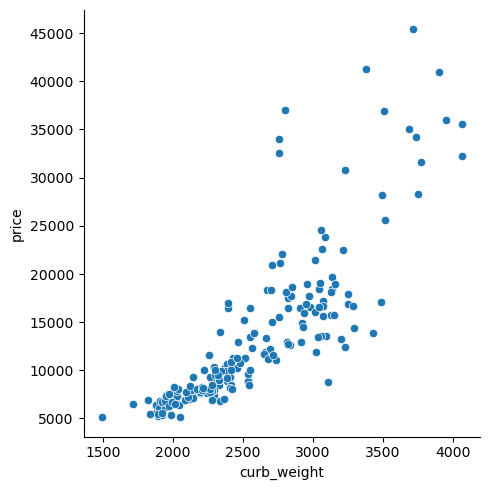

In [12]:
sns.relplot(x="curb_weight", y="price", data=df)

The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates two price populations with different trends within the horsepower feature. This indicates that fuel_type contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

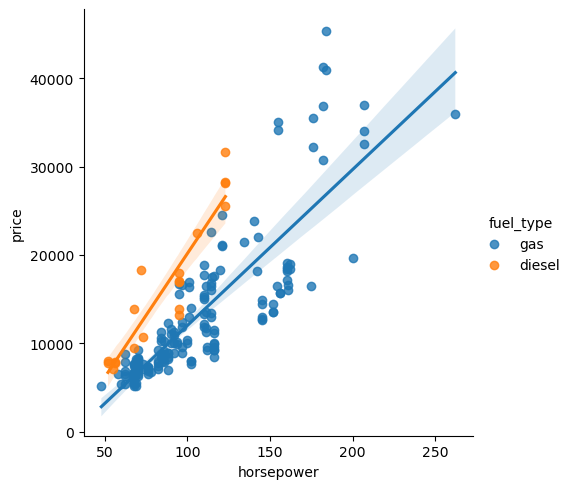

In [13]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df)

In [14]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

## AMES

In [15]:
ames = pd.read_csv("data/ames.csv")
ames.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


In [16]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0
                                      )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [17]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

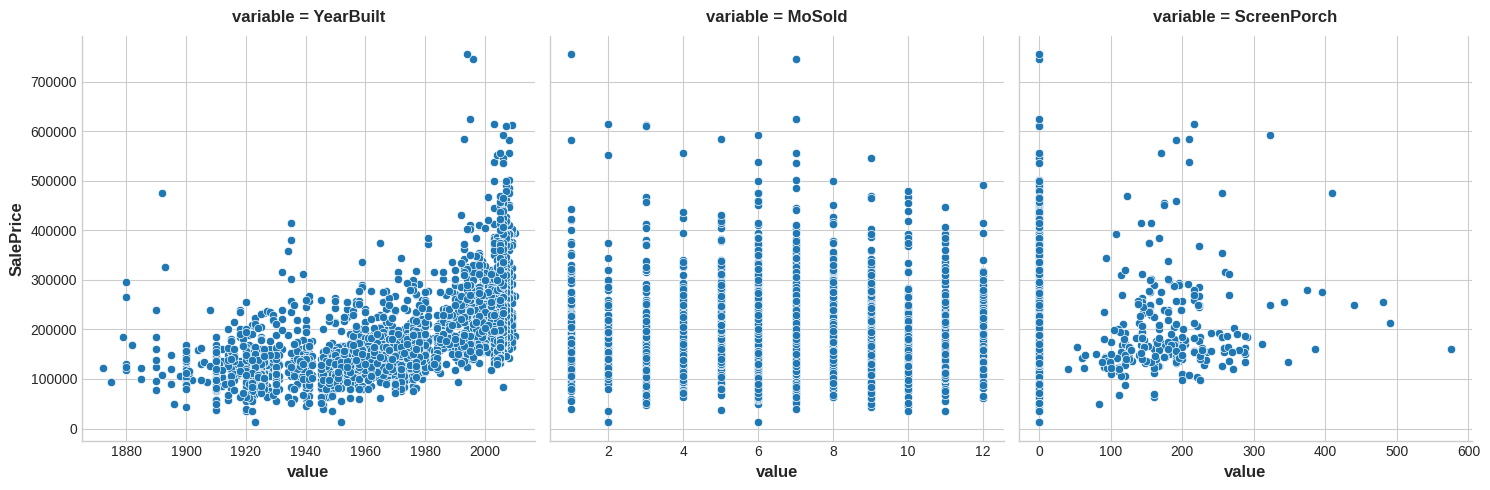

In [18]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=ames.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False)
);

#### AMES Mutual Information

In [19]:
X = ames.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


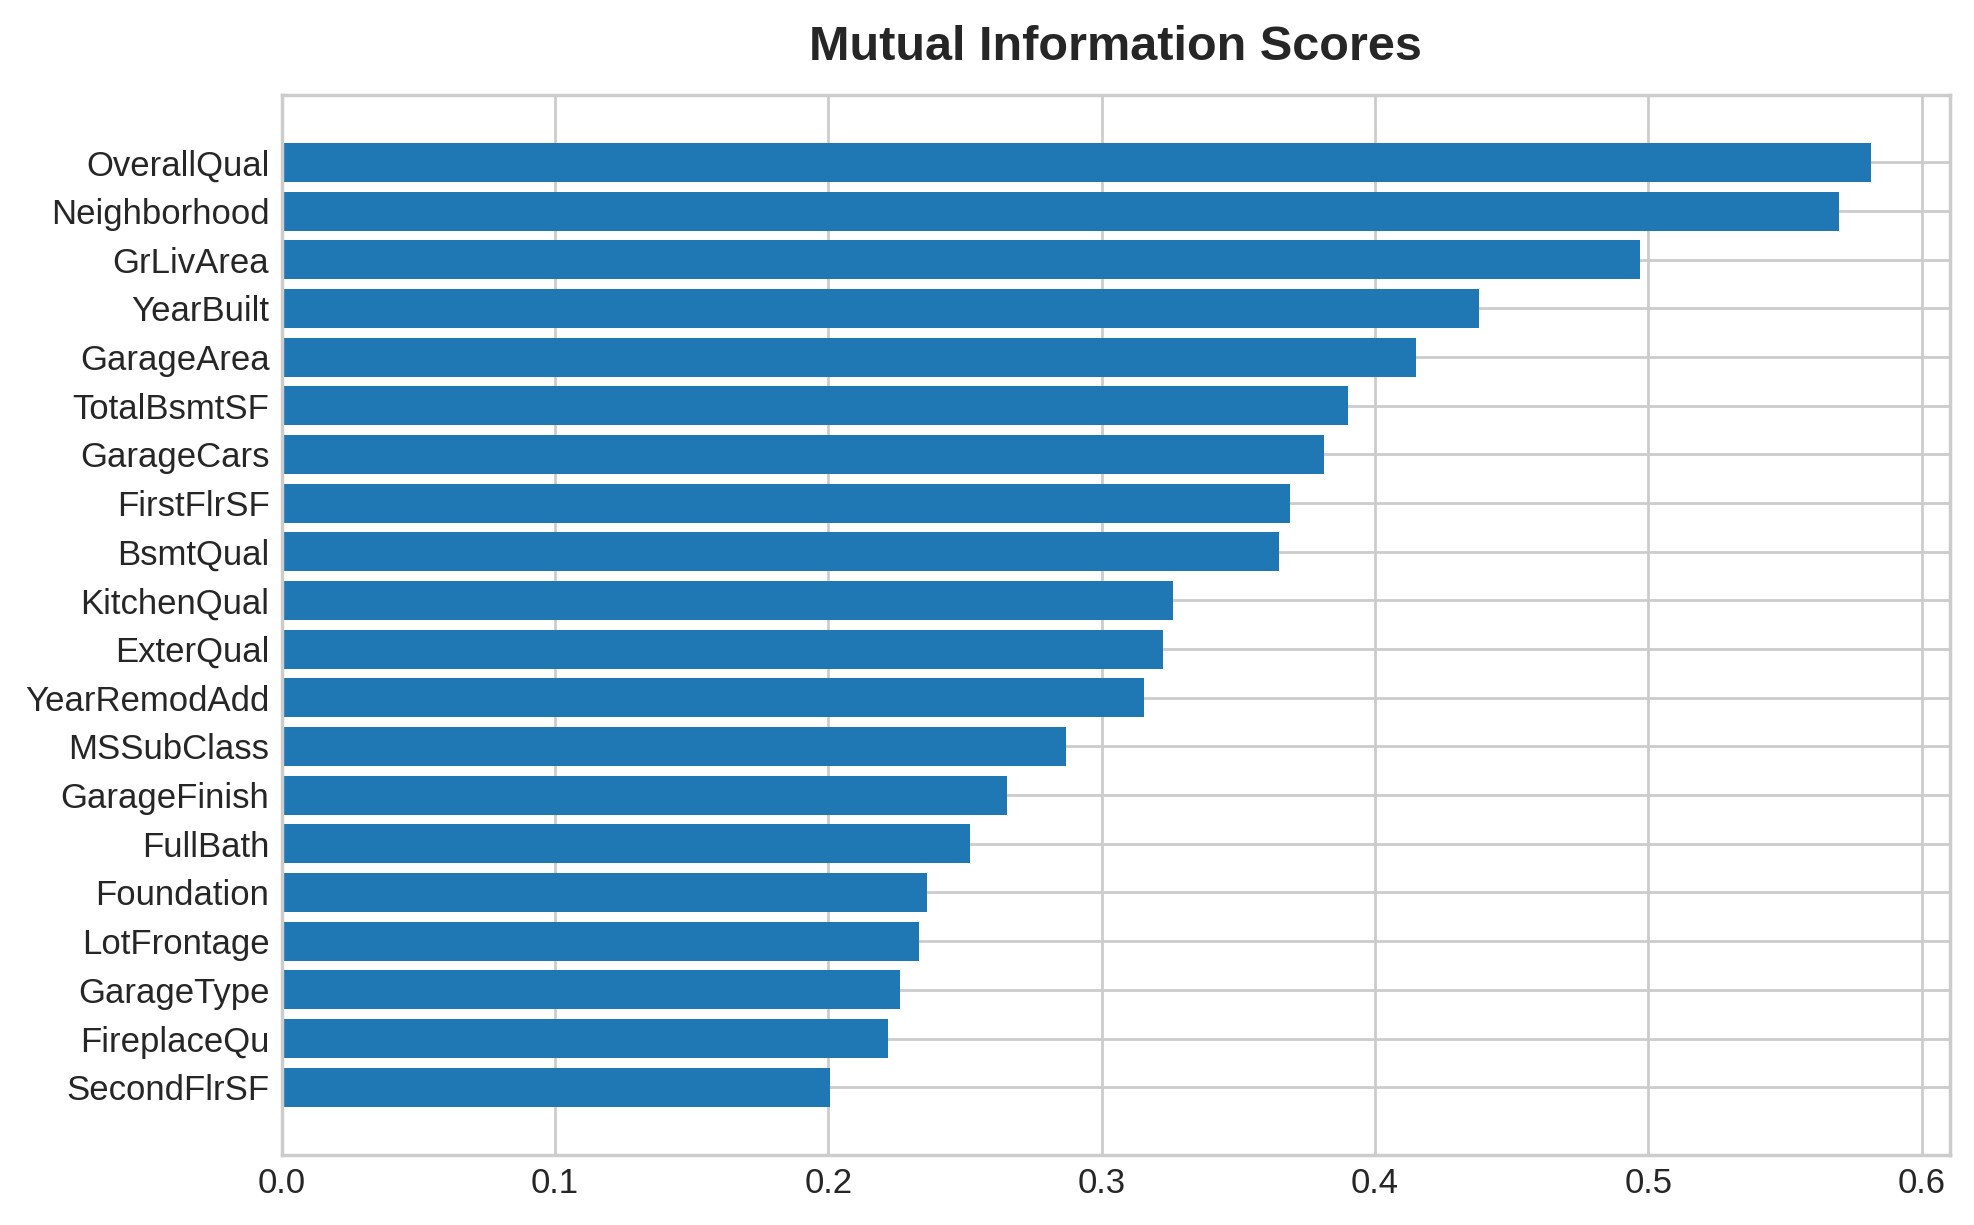

In [20]:
print(mi_scores.head(20))

plt.figure(dpi=250, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

#### Examine the MI Scores
The highest rank is neighborhood, and so on from up to bottom.

Then, I'll investigate possible interaction effects for the BldgType feature. This feature describes the broad structure of the dwelling in five categories:
- 1Fam	Single-family Detached
- 2FmCon	Two-family Conversion; originally built as one-family dwelling
- Duplx	Duplex
- TwnhsE	Townhouse End Unit
- TwnhsI	Townhouse Inside Unit

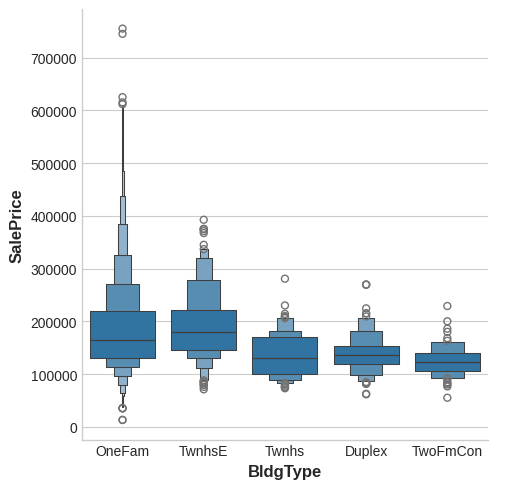

In [21]:
sns.catplot(x="BldgType", y="SalePrice", data=ames, kind="boxen")

I then investigate whether BldgType produces a significant interaction with either of the following:
- GrLivArea  # Above ground living area
- MoSold     # Month sold


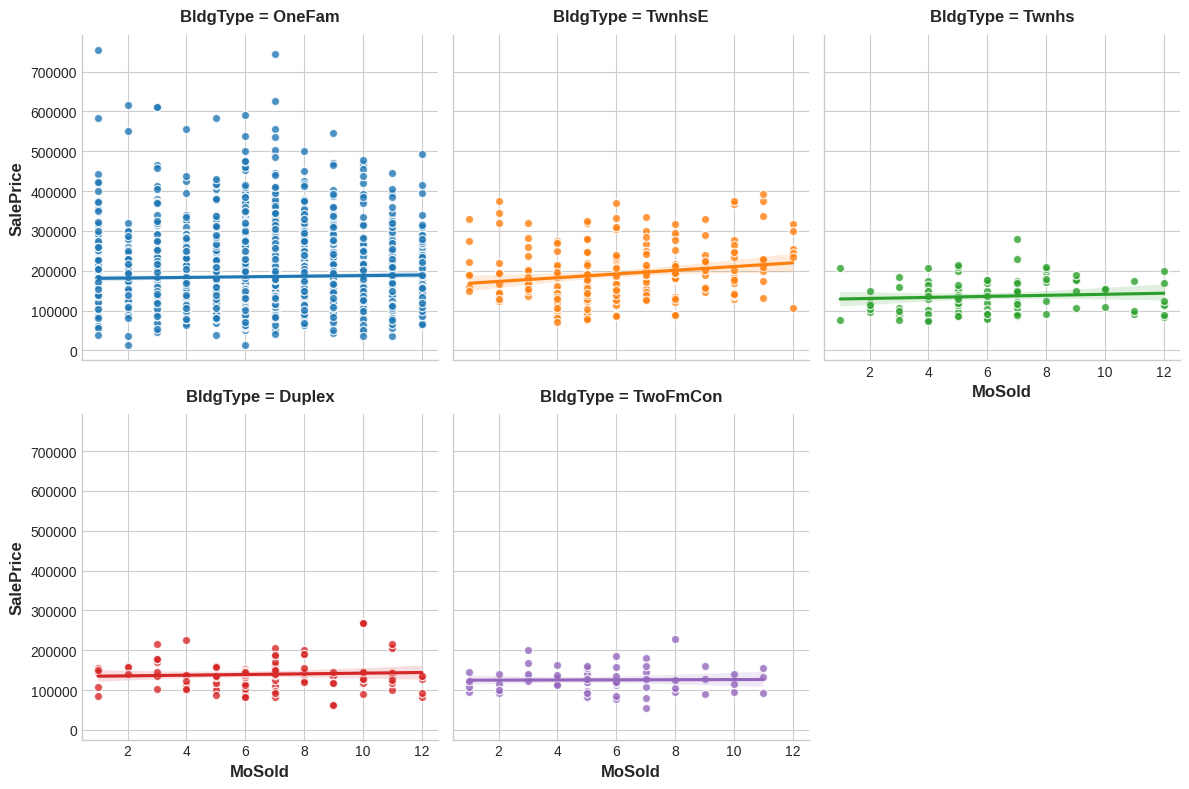

In [22]:
feature = "MoSold"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=ames, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

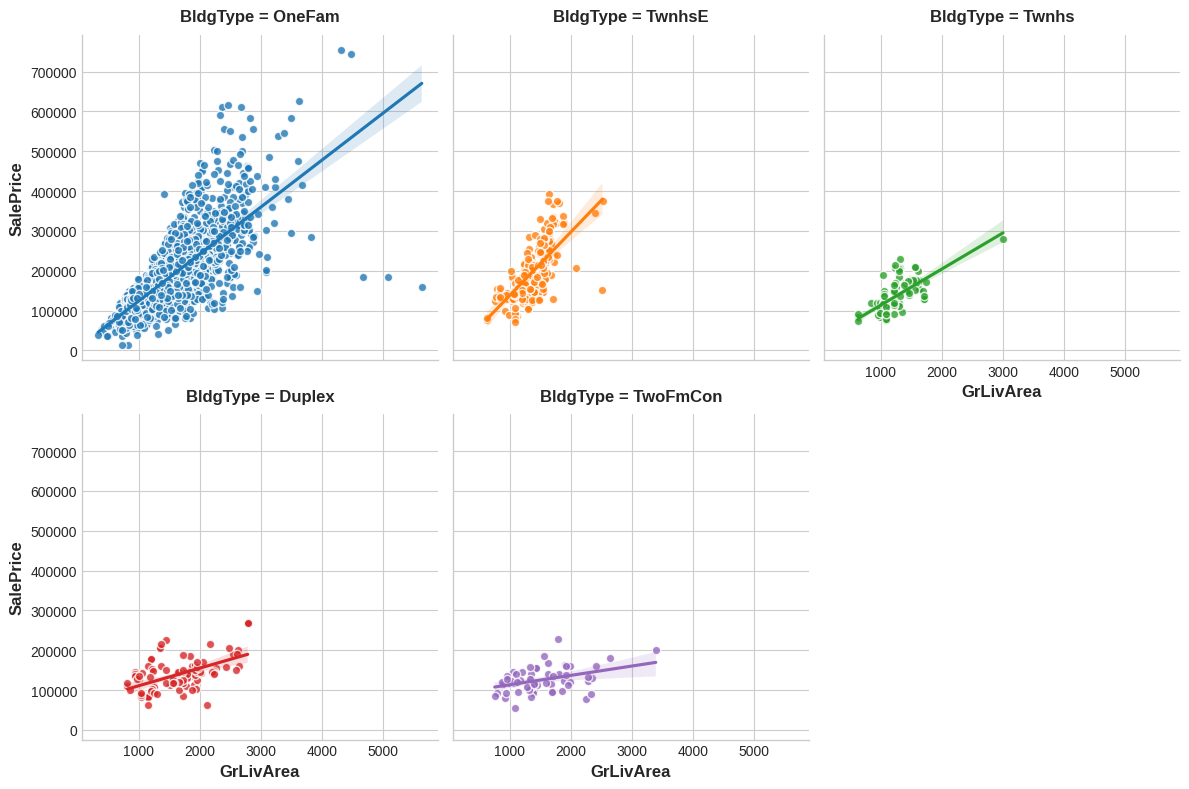

In [23]:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=ames, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

**Analysis**:

The trends lines within each category of BldgType are clearly very different, indicating an interaction between these features are real. Since knowing BldgType tells me more about how GrLivArea relates to SalePrice, I should consider including BldgType in my feature set.

The trend lines for MoSold, however, are almost all the same. This feature hasn't become more informative for knowing BldgType.

In [67]:
# Top ten features
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

# Creating Features

After analysing features using metric utility, I can now creating features based on prior analysis of mutual information.

In [46]:
# Reading required data

accidents = pd.read_csv("data/accidents.csv")
autos = pd.read_csv("data/autos.csv")
concrete = pd.read_csv("data/concrete.csv")
customer = pd.read_csv("data/customer.csv")


**NOTES ON CREATING FEATURES:**
- Understand the features by studying the dataset documentationn (if available)
- Research the problem domain to acquire domain knowledge (books and jurnals are best sources)
- Study prev work
- Use data visualization to reveal pathologies in the distribution and study the relationships between variables.

## Mathematical Transforms
Relationship among features often better understood when mathematical formula is applied. I'll use pandas to do that.

In [26]:
autos["stroke_ratio"] = autos.stroke / autos.bore # make new column based on the calculation of other columns
autos[["stroke", "bore", "stroke_ratio"]]

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831
...,...,...,...
188,3.15,3.78,0.833333
189,3.15,3.78,0.833333
190,2.87,3.58,0.801676
191,3.40,3.01,1.129568


**NOTE**: the mode complex the combination is, the more difficult for the model to learn from it. The following is the example of 

In [27]:
autos['displacement'] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)

Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

In [31]:
accidents.columns

Index(['Severity', 'StartTime', 'EndTime', 'StartLat', 'StartLng', 'Distance',
       'Street', 'City', 'State', 'Zipcode', 'Temperature', 'Humidity',
       'Pressure', 'Visibility', 'WindSpeed', 'Precipitation',
       'WeatherCondition', 'Amenity', 'Bump', 'Crossing', 'GiveWay',
       'Junction', 'NoExit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'TrafficCalming', 'TrafficSignal', 'LongWingSpeed'],
      dtype='object')

<Axes: xlabel='LongWingSpeed', ylabel='Density'>

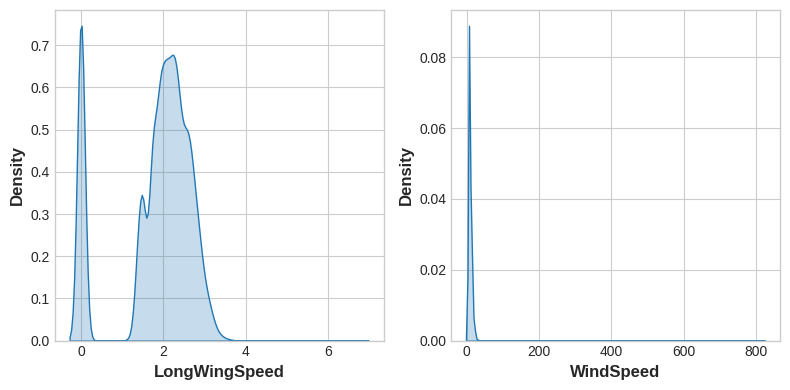

In [34]:
accidents['LongWingSpeed']=accidents.WindSpeed.apply(np.log1p)

# plot comparison
fig, axs = plt.subplots(1, 2, figsize=(8,4))
sns.kdeplot(accidents.WindSpeed, fill=True, ax=axs[1])
sns.kdeplot(accidents.LongWingSpeed, fill=True, ax=axs[0])

## Counts
Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. We can aggregate such features by creating a count.

These features will be binary (1 for Present, 0 for Absent) or boolean (True or False). In Python, booleans can be added up just as if they were integers.

In Traffic Accidents are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the sum method:

In [68]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


We could also use a dataframe's built-in methods to create boolean values. In the Concrete dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than gt method:

In [39]:
components = ["Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
                "Superplasticizer", "CoarseAggregate", "FineAggregate"]

concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5


## Building-Up and Breaking-Down Features

We sometimes or if not often have complex strings in our dataset. That strings can usefully be broken into simpler pieces. Some common example:
- ID Numbers: 123-45-6789'
- Phone numbers: '(+62) 813-4680-3227'
- Street addresses: '78124 Paris 2., Pontianak, Kalimantan Barat'
- Internet addresses: 'http://oktavianuu.github.io'
- Product codes: '0 36000 29145 2'
- Dates and times: 'Mon Sep 30 07:06:05 2025'

Features like these will often have some kind of structure that we can make use of. ID phone numbers, for instance, have an area code (the '(+62)' part) that tells us the location of the caller. As always, some research can pay off here.

The str accessor lets us apply string methods like split directly to columns. The Customer Lifetime Value dataset contains features describing customers of an insurance company. From the Policy feature, we could separate the Type from the Level of coverage:

In [48]:
customer[["Type", "Level"]] = ( # create two new features
    customer["Policy"] # from the policy features
    .str # through string accesor
    .split(" ", expand=True) # by splitting on " " and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


Simple features could also be joined into a composed feature if we had reason to believe there was some interaction in the combination:

In [52]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head(10)

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan
5,audi,sedan,audi_sedan
6,audi,sedan,audi_sedan
7,audi,wagon,audi_wagon
8,audi,sedan,audi_sedan
9,bmw,sedan,bmw_sedan


## Group Transforms

Group transforms aggregate information across multiple rows grouped by some category. With a group transform we can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If we had discovered a category interaction, a group transform over that categry could be something good to investigate.

Using aggregation function, a group transfroms combine two features, one feature is the categorical that provides the grouping and another feature provide the values which we wish to aggregate.

For an "average income by state", we would choose State for the grouping feature, mean for the aggregation function, and Income for the aggregated feature. To compute this in Pandas, we use the groupby and transform methods:

In [57]:
customer["AverageIncome"] = (customer.groupby("State") # Each state
    ["Income"] # Select income
    .transform("mean") # computes it mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


The mean function is a built-in dataframe method, which means we can pass it as a string to transform. Other handy methods include max, min, median, var, std, and count. I can calculate frequency with which each state occurs in the dataset as follow:

In [61]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


We could use a transform like this to create a "frequency encoding" for a categorical feature.

If we're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's merge method after creating a unique set of values with drop_duplicates on the training set:

In [65]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)


# create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Basic,380.346464
1,Extended,486.014366
2,Basic,380.346464
3,Basic,380.346464
4,Basic,380.346464
5,Premium,686.062978
6,Basic,380.346464
7,Basic,380.346464
8,Basic,380.346464
9,Premium,686.062978


## Guidelines for creating features

- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
- Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

In [ ]:
In